In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

# Toggle cell visibility
from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)


## Stvaranje PID-regulatora korištenjem operacijskih pojačala

U analognoj elektronici, operacijska pojačala uobičajeno se koriste za realizaciju proporcionalno-integracijski-derivacijskih (PID) regulatora. Dok matematički modeli linearnih vremenski-nepromjenjivih (LTI) sustava pretpostavljaju idealne uvjete, realni sklopovi možda im ne odgovaraju u potpunosti.

U većini slučajeva idealni model daje prihvatljive rezultate, ali frekvencijske karakteristike mogu se bolje aproksimirati proširivanjem modela s pojačanjem otvorene petlje:
<br><br>
$$G_{ideal}(s)=\frac{V_{out}}{V_{in}}=-\frac{Z_F}{Z_G}\qquad\qquad G_{approx}(s)=\frac{V_{out}}{V_{in}}=-\frac{\frac{-A\cdot Z_F}{Z_G+Z_F}}{1+\frac{A\cdot Z_G}{Z_G+Z_F}}$$
<br>

U ovom ćemo primjeru istražiti neke od konfiguracija PID regulatora zasnovanih na operacijskim pojačalima.<br>
<b>Prvo, odaberite vrijednost pojačanja otvorene petlje za prikazane izračune!</b>



In [2]:
# Model selector
opampGain = w.ToggleButtons(
    options=[('2 000', 2000), ('10 000', 10000), ('50 000', 50000), ('200 000', 200000), ('500 000', 500000)],
    description='Pojačanje operacijskog pojačala: ', style={'description_width':'18%'})

display(opampGain)

ToggleButtons(description='Pojačanje operacijskog pojačala: ', options=(('2 000', 2000), ('10 000', 10000), ('…

Postoji velik broj različitih konfiguracija PID regulatora, ali one općenito moraju uključivati kondenzatore i otpornike u unaprijednoj i povratnoj vezi. U našem primjeru, unaprijedna veza sadrži serijski povezani par kondenzator-otpornik paralelno spojen s drugim otpornikom, dok se povratna veza sastoji od još jednog serijski povezanog para kondenzator-otpornik.
<br><br>
<img src="Images/pid.png" width="30%" />
<br>
<b>Prilagodite pasivne komponente tako da neidealni model bude najbliži idealnom! Gdje karakteristike značajno odstupaju od idealnih? Što se može reći o grafu faze?</b>

<IPython.core.display.Javascript object>


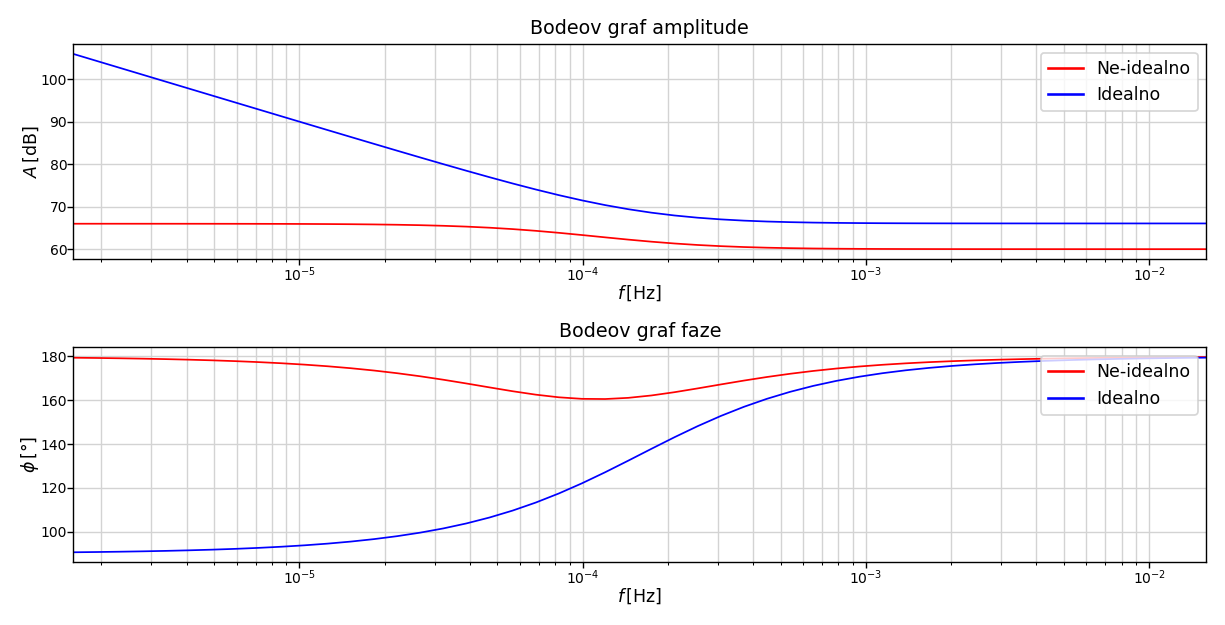

Output()

In [3]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

l1 = f1_ax1.plot([], [], color='red')
l2 = f1_ax2.plot([], [], color='red') 
l3 = f1_ax1.plot([], [], color='blue')
l4 = f1_ax2.plot([], [], color='blue')  

f1_line1 = l1[0]
f1_line2 = l2[0]
f1_line3 = l3[0]
f1_line4 = l4[0]
    
f1_ax1.legend(l1+l3, ['Ne-idealno', 'Idealno'], loc=1)
f1_ax2.legend(l2+l4, ['Ne-idealno', 'Idealno'], loc=1)

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bodeov graf amplitude', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bodeov graf faze', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)  

# System model

def system_model(cg, r1, r2, cf, rf, a):

    Rf = rf / 1000      # Convert to Ohm
    R1 = r1 / 1000
    R2 = r2 / 1000
    Cf = cf * 1000000   # Convert to Farad
    Cg = cg * 1000000

    A = Rf*(R1+R2)*Cf*Cg
    B = Rf*Cf+(R1+R2)*Cg
    C = R1*R2*Cf*Cg
    D = Cf*R2
    
    W_ideal = c.tf([-A, -B, -1], [C, D, 0])
    W_ac = c.tf([-a*A, -a*B, -a], [A+(a+1)*C, B+(a+1)*D, 1])
    
    global f1_line1, f1_line2, f1_line3, f1_line4
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f1_line3, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line4, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()
    
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
    print('Prijenosna funkcija za idealni PID:')
    print(W_ideal)
    print('\nPrijenosna funkcija za ne-idealni PID:')
    print(W_ac)
    
# GUI widgets

cg_slider = w.FloatLogSlider(value=0.01, base=10, min=-3, max=3, description=r'$C_g$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})    
r1_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=3, description=r'$R_1$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
r2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_2$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cf_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=3, description=r'$C_f$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
rf_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system_model, {'cg':cg_slider, 'r1':r1_slider, 'r2':r2_slider,
                                                 'cf':cf_slider, 'rf':rf_slider, 'a':opampGain})

display(w.VBox([w.HBox([cg_slider, r1_slider, r2_slider]),
                w.HBox([cf_slider, rf_slider])]), input_data)